In [2]:
import os
import json
import pandas as pd
import numpy as np
import geopandas as gpd
from shapely.geometry import Point, Polygon

## Get parameter-group 1: FARM, location, crop name, yield, area

In [11]:
# data loader

# get farm data
def get_farm_data(farm_id):
    # dir = os.path.dirname(__file__)
    dir = os.getcwd()
    farm_data_path = os.path.join(dir, '../data/test/litefarm_test.csv')
    df = pd.read_csv(farm_data_path)
    
    farm = df.query(f"farm_id == '{farm_id}'")
    
    area = farm["area_in_m2"].iloc[0] * 0.0001  # Litefarm database use m^2 while holos calculation use ha
    crop_yield = farm["yield_kg_per_m2"].iloc[0] / area  # kg/ha
    location = [Point(x, y) for x, y in zip(df['lon'], df['lat'])]
    crop_name = farm["common_crop_name"].iloc[0]
    year = farm["year"].iloc[0]
    
    return {'area': area, 'location': location, 'crop': crop_name, 'yield': crop_yield, 'year': year}

In [12]:
# test
farm_id = '0369f026-1f90-11ee-b788-0242ac150004'
get_farm_data(farm_id)

{'area': 0.1409,
 'location': [<POINT (-71.519 46.476)>],
 'crop': 'Soybean',
 'yield': 1.9162526614620299,
 'year': 2021}

## Get parameter-group 2: MODIFIERS / reduction factors, RF_*

In [13]:
def add_province():
    # get the province base on the farm location
    farm_data = get_farm_data(farm_id)
    farm_point = gpd.GeoDataFrame({'geometry': farm_data["location"]}, crs="EPSG:4326")
        
    dir = os.getcwd()
    province_shp_path = os.path.join(dir, '../data/external/province_500m')
    provinces = gpd.read_file(province_shp_path)
    provinces = provinces.to_crs("EPSG:4326") 

    farm_province = gpd.sjoin(farm_point, 
                         provinces[["PRENAME", "geometry"]], 
                         how='left', 
                         predicate='within').drop(columns=['index_right'])
    
    farm_province.rename(columns={'PRENAME': 'province'}, inplace=True)
    
    return farm_province

In [14]:
# test
add_province()

,geometry,province
0,POINT (-71.51895 46.47619),Quebec


In [15]:
def get_province():
    province = add_province()["province"].iloc[0]
    return province

In [16]:
# TEST
get_province()

'Quebec'

In [17]:
def get_region():
    province = get_province()
    western_canada = [
        'Alberta', 'British Columbia', 'Manitoba', 
        'Saskatchewan', 'Northwest Territories', 'Nunavut'
    ]
    
    if province in western_canada:
        return 'western_canada'
    else:
        return 'eastern_canada'

In [18]:
# test
get_region()

'eastern_canada'

In [19]:
def get_modifiers(rf_am='default', rf_cs='Annual', rf_ns='RF_NS_CRN', tillage='unknown', soil_texture='unknown'):
    # get reduction factors, RF_*
    # reduction factors: coefficient used to estimate the decrease in N2O 
    # emissions resulting from specific management practices compared to a baseline scenario. 
    region = get_region()
    
    dir = os.getcwd()
    RF_AM_path = os.path.join(dir, '../data/preprocessed/modifier_rf_am.csv')
    RF_CS_path = os.path.join(dir, '../data/preprocessed/modifier_rf_cs.csv')
    RF_NS_path = os.path.join(dir, '../data/preprocessed/modifier_rf_ns.csv')
    RF_Till_path = os.path.join(dir, '../data/preprocessed/modifier_rf_till.csv')
    RF_TX_path = os.path.join(dir, '../data/preprocessed/modifier_rf_tx.csv')

    RF_AM_df = pd.read_csv(RF_AM_path)
    RF_CS_df = pd.read_csv(RF_CS_path)
    RF_NS_df = pd.read_csv(RF_NS_path)
    RF_Till_df = pd.read_csv(RF_Till_path)
    RF_TX_df = pd.read_csv(RF_TX_path)

    # RF_AM, application method, LiteFarm data do not have this field, use default 1.
    RF_AM = RF_AM_df.query(f"method == '{rf_am}'")['value'].iloc[0]

    # RF_CS, currently the calculation method only involves annual, thus use 'Annual' by default, 1
    RF_CS = RF_CS_df.query(f"group == '{rf_cs}'")['value'].iloc[0]

    # RF_NS, current calculation only involves crop residue nitrogen, thus only RF_NS_CRN is used
    RF_NS = RF_NS_df.query(f"N_source == '{rf_ns}'")['value'].iloc[0]

    # RF_Till, by default set as 1 "unknown", LiteFarm data do not provide this information
    RF_Till = RF_Till_df.query(f"region=='{region}' & tillage == '{tillage}'")['value'].iloc[0]

    # RF_TX
    # here should link to Ftopo data, need to do!
    RF_TX = RF_TX_df.query(f"region=='{region}' & soil_texture == '{soil_texture}'")['value'].iloc[0]

    return {"RF_AM": RF_AM, "RF_CS": RF_CS, "RF_NS": RF_NS, "RF_Till": RF_Till, "RF_TX": RF_TX}

In [20]:
# test
get_modifiers()

{'RF_AM': 1.0, 'RF_CS': 1.0, 'RF_NS': 0.84, 'RF_Till': 1.0, 'RF_TX': 1.0}

## Get parameter-group 3: CROP GROUP parameters: Carbon_concentration, S_s, S_r, S_p

In [21]:
# def map_simplified_crop_name():
    # LiteFarm has a flexible protocol for crop names, 
    # thus, map crop name to simplified version???
    # need to figure out how to do this?
    # or this should be something that LiteFarm team do
    # for now, we assume the crop name is clean and ready-to-use.
    

In [24]:
def get_crop_group():
    # determine the group of crops: annual, perennial, cover, silage, root.
    farm_data = get_farm_data(farm_id)
    crop = farm_data['crop']
    
    dir = os.getcwd()
    crop_to_group_map_path = os.path.join(dir, '../data/preprocessed/crop_to_group.csv')
    crop_to_group_map_df = pd.read_csv(crop_to_group_map_path)

    crop_group = crop_to_group_map_df.query(f"crop == '{crop}'")['group'].iloc[0]

    return crop_group

In [25]:
# test
get_crop_group()

'Annual'

In [26]:
def get_crop_group_parameters():
    # get crop-group related parameters: Carbon_concentration, S_s, S_r, S_p
    crop_group = get_crop_group()

    dir = os.getcwd()
    crop_group_params_path = os.path.join(dir, '../data/preprocessed/crop_group_parameters.csv')
    crop_group_params_df = pd.read_csv(crop_group_params_path)

    crop_group_params = crop_group_params_df[crop_group_params_df['group'] == crop_group].iloc[0].to_dict()
    return crop_group_params

In [27]:
# test
get_crop_group_parameters()

{'group': 'Annual',
 'carbon_concentration': 0.45,
 'S_s': 100,
 'S_r': 100,
 'S_p': 2}

## Get parameter-group 4: CROP parameters: N_*, and R_*

In [28]:
def get_crop_parameters():
    # get crop specific parameters: N_p, N_s, N_r, N_e, R_p, R_s, R_r, R_e
    farm_data = get_farm_data(farm_id)
    crop = farm_data['crop']

    dir = os.getcwd()
    crop_params_path = os.path.join(dir, '../data/preprocessed/crop_parameters.csv')
    crop_params_df = pd.read_csv(crop_params_path)
    crop_params_df.head()

    crop_params = crop_params_df[crop_params_df['crop'] == crop].iloc[0].to_dict()
    crop_params.pop('group', None) 
    crop_params.pop('holos_crop_name', None)
    
    return crop_params

In [29]:
# test
get_crop_parameters()

{'crop': 'Soybean',
 'condition': 'Canada',
 'moisture': 14,
 'R_p': 0.304,
 'R_s': 0.455,
 'R_r': 0.146,
 'R_e': 0.095,
 'N_p': 67.0,
 'N_s': 6.0,
 'N_r': 10.0,
 'N_e': 10.0}

## Get parameter-group 5: CLIMATE parameters, P, PE, and Ftopo

In [30]:
def get_climate_parameters():
    # currently, we use the default Holos data derived from SLC
    add_province()

In [39]:
farm_gdf = add_province()
farm_gdf

,geometry,province
0,POINT (-71.51895 46.47619),Quebec


In [32]:
dir = os.getcwd()
default_climate_path = os.path.join(dir, '../data/raw/Holos/ecodistrict_to_ecozone_mapping.csv')
slc_polygons_path = os.path.join(dir, '../data/external/slc')
default_climate_df = pd.read_csv(default_climate_path)
# slc_polygons = gpd.read_file(slc_polygons_path)
# slc_polygons = slc_polygons.set_crs('EPSG:4269', inplace=True)
# slc_polygons = slc_polygons.to_crs('EPSG:4326')

In [33]:
default_climate_df.head()

,Ecodistrict,Ecozone,Province,PMayToOct,PEMayToOct,Ftopo,SoilType,SoilTexture
0,358,Boreal Shield West,Manitoba,348,453,0.00,Brown Chernozem,Coarse
1,358,Boreal Shield West,Saskatchewan,348,453,0.00,Brown Chernozem,Coarse
2,371,Boreal Shield West,Manitoba,376,581,0.33,Black/Gray Chernozem,Fine
3,371,Boreal Shield West,Ontario,376,581,0.33,Eastern Canada,Fine
4,375,Boreal Shield West,Manitoba,411,579,0.33,Black/Gray Chernozem,Fine


In [58]:
ecodistrict = gpd.read_file("../data/external/slc_dissolved_ecodistrict")
ecodistrict = ecodistrict.to_crs('EPSG:4326')
ecodistrict.head()

,ECO_ID,AREA,PERIMETER,geometry
0,1,1.379902,18.141771,"POLYGON ((-81.82100 80.84613, -81.86701 80.842..."
1,2,7.099515,65.471834,"POLYGON ((-78.14311 79.33501, -78.24853 79.337..."
2,3,2.019555,17.852421,"POLYGON ((-91.08031 79.05304, -91.07503 79.030..."
3,4,6.354904,61.917720,"POLYGON ((-82.29263 74.51720, -82.27618 74.542..."
4,5,0.292293,3.152396,"POLYGON ((-74.21592 71.20401, -74.22913 71.201..."


In [41]:
farm_polygons = gpd.sjoin(farm_gdf, 
                          ecodistrict[["ECO_ID", "geometry"]],
                          how='left', 
                          predicate='within'
                         ).drop(columns=['index_right'])
farm_polygons.head()

,geometry,province,ECO_ID
0,POINT (-71.51895 46.47619),Quebec,540


In [42]:
farm_ecodistrict_climate = pd.merge(farm_polygons, default_climate_df,
                                    how='left',
                                    left_on=['ECO_ID','province'],
                                    right_on = ['Ecodistrict','Province'])
farm_ecodistrict_climate

,geometry,province,ECO_ID,Ecodistrict,Ecozone,Province,PMayToOct,PEMayToOct,Ftopo,SoilType,SoilTexture
0,POINT (-71.51895 46.47619),Quebec,540,540,Mixedwood Plains,Quebec,652,556,11.71,Eastern Canada,Coarse


In [43]:
farm_ecodistrict_climate = farm_ecodistrict_climate.drop(columns=['ECO_ID', 'Ecozone', 'province', 'SoilType'])
farm_ecodistrict_climate

,geometry,Ecodistrict,Province,PMayToOct,PEMayToOct,Ftopo,SoilTexture
0,POINT (-71.51895 46.47619),540,Quebec,652,556,11.71,Coarse


In [44]:
soil_texture = farm_ecodistrict_climate["SoilTexture"].iloc[0]
soil_texture

'Coarse'

In [45]:
P_i = farm_ecodistrict_climate["PMayToOct"].iloc[0]
P_i

652

In [46]:
PE_i = farm_ecodistrict_climate["PEMayToOct"].iloc[0]
PE_i

556

In [47]:
Ftopo = farm_ecodistrict_climate["Ftopo"].iloc[0]
Ftopo

11.71

In [48]:
climate_dict = {"soil_texture": soil_texture, "P": P_i, "PE": PE_i, "FR_Topo": Ftopo}
climate_dict

{'soil_texture': 'Coarse', 'P': 652, 'PE': 556, 'FR_Topo': 11.71}

In [87]:
import random

# Function to generate random points within a polygon
def generate_random_points(polygon, num_points=20):
    points = []
    min_x, min_y, max_x, max_y = polygon.bounds
    while len(points) < num_points:
        random_point = Point([random.uniform(min_x, max_x), random.uniform(min_y, max_y)])
        if random_point.within(polygon):  # Check if point is within the polygon
            points.append(random_point)
    return points

def extract_lon_lat(points):
    return [(point.x, point.y) for point in points]

In [59]:
eco_id = farm_ecodistrict_climate["Ecodistrict"].iloc[0]
eco_id


540

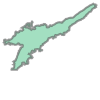

In [61]:
farm_ecodistrict = ecodistrict.query(f"ECO_ID == {eco_id}")
farm_ecodistrict_geometry = farm_ecodistrict["geometry"].iloc[0]
farm_ecodistrict_geometry

In [70]:
farm_gdf

,geometry,province
0,POINT (-71.51895 46.47619),Quebec


In [71]:
ecodistrict

,ECO_ID,AREA,PERIMETER,geometry
0,1,1.379902,18.141771,"POLYGON ((-81.82100 80.84613, -81.86701 80.842..."
1,2,7.099515,65.471834,"POLYGON ((-78.14311 79.33501, -78.24853 79.337..."
2,3,2.019555,17.852421,"POLYGON ((-91.08031 79.05304, -91.07503 79.030..."
3,4,6.354904,61.917720,"POLYGON ((-82.29263 74.51720, -82.27618 74.542..."
4,5,0.292293,3.152396,"POLYGON ((-74.21592 71.20401, -74.22913 71.201..."
...,...,...,...,...
1022,9607,0.344528,5.876613,"POLYGON ((-113.82061 57.83890, -113.81799 57.8..."
1023,9608,0.118577,3.631640,"POLYGON ((-111.66100 56.61017, -111.66929 56.6..."
1024,9609,0.049116,1.305630,"POLYGON ((-111.75039 55.09389, -111.73839 55.0..."
1025,9687,0.031676,0.872767,"POLYGON ((-111.95540 53.80763, -111.96202 53.8..."


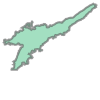

In [79]:
farm_ecodistrict = gpd.sjoin(ecodistrict, 
                          farm_gdf, 
                          how='inner', 
                          predicate='contains')
farm_ecodistrict_polygon = farm_ecodistrict["geometry"].iloc[0]
farm_ecodistrict_polygon

In [89]:
random_points = generate_random_points(farm_ecodistrict_polygon, num_points=5)
random_points

[<POINT (-72.025 46.214)>,
 <POINT (-71.471 46.486)>,
 <POINT (-72.905 46.303)>,
 <POINT (-72.35 46.444)>,
 <POINT (-71.242 46.761)>]

In [84]:
# random_points_geoseries = gpd.GeoSeries(random_points_list)
# random_points_geoseries

In [92]:
point_coords = extract_lat_lon(random_points)

In [93]:
for point in point_coords:
    longitude, latitude = point
    print(longitude)

-72.02493974881644
-71.47096607806353
-72.90519513708634
-72.3495249705811
-71.24224227606553


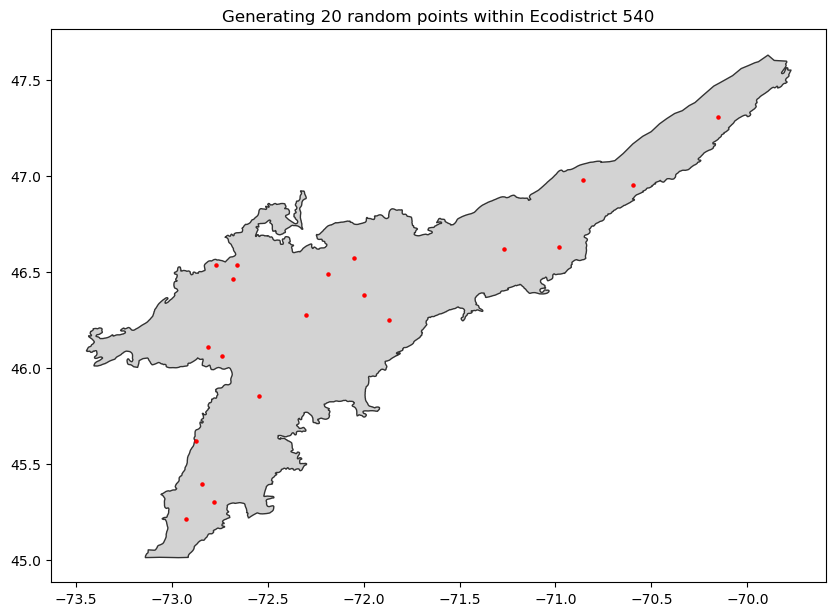

In [66]:
import matplotlib.pyplot as plt
from shapely.geometry import Point, Polygon

fig, ax = plt.subplots(figsize=(10, 8))

# Plot the provinces first
farm_ecodistrict_geometry = gpd.GeoDataFrame(geometry=[farm_ecodistrict_geometry])
farm_ecodistrict_geometry.plot(ax=ax, edgecolor="0.2", color='lightgrey')
random_points_geoseries.plot(ax=ax, marker='o', color='red', markersize=5)

plt.title(f"Generating 20 random points within Ecodistrict {eco_id}")
plt.show()

In [3]:
import rasterio
import pandas as pd

In [39]:
# Function to get the raster value at a given latitude and longitude
def get_raster_value(raster_path, lon, lat):
    with rasterio.open(raster_path) as src:
        # Convert geographic coordinates to raster coordinates
        row, col = src.index(lon, lat)
        # Read the raster value at the computed coordinates
        return src.read(1)[row, col]  # band 1 contains the data

In [40]:
raster_path = '../data/external/HWSD2_RASTER/HWSD2.bil'

In [41]:
# Coordinates
longitude = -88.86
latitude = 54.39

In [42]:
smu_id = get_raster_value(raster_path, longitude, latitude)
smu_id

6707

In [60]:
# Function to lookup texture USDA and value
def lookup_texture_and_value(smu_id, smu_csv_path, texture_csv_path, texture_mapped_path):

    smu_df = pd.read_csv(smu_csv_path)
    texture_df = pd.read_csv(texture_csv_path)
    mapped_value_df = pd.read_csv(texture_mapped_path)
    
    # Find TEXTURE_USDA from HWSD2_SMU using HWSD2_SMU_ID
    texture_code = smu_df[smu_df['HWSD2_SMU_ID'] == smu_id]['TEXTURE_USDA'].iloc[0]
    
    # Find VALUE from D_TEXTURE_USDA using TEXTURE_USDA
    texture_type = texture_df[texture_df['CODE'] == texture_code]['VALUE'].iloc[0]

    # Find the mapped value that will be used in N2O calculation
    texture_mapped_value = mapped_value_df[mapped_value_df['VALUE']==texture_type]['AWC'].iloc[0]
    
    return texture_code, texture_type, texture_mapped_value

In [61]:
smu_csv_path = '../data/external/HWSD2/HWSD2_SMU.csv'
texture_csv_path = '../data/external/HWSD2/D_TEXTURE_USDA.csv'
texture_mapped_path = '../data/preprocessed/soil_texture_mapped_values.csv'

# Get texture USDA and value
texture_code, texture_type, texture_mapped_value = lookup_texture_and_value(smu_id, smu_csv_path, texture_csv_path, texture_mapped_path)

print(f"SMU ID: {smu_id}, TEXTURE TYPE: {texture_type}, mapped VALUE: {texture_mapped_value}")

SMU ID: 6707, TEXTURE TYPE: Sandy loam, mapped VALUE: 125


In [72]:
import os
import rasterio
import pandas as pd

class ExternalSoilTextureDataFetcher:
    def __init__(self, points):
        self.points = points
        # self.dir = os.path.dirname(__file__)
        self.dir = os.getcwd()
        self.smu_csv_path = os.path.join(self.dir, 
                                         '../data/external/HWSD2/HWSD2_SMU.csv') 
        self.texture_csv_path = os.path.join(self.dir, 
                                             '../data/external/HWSD2/D_TEXTURE_USDA.csv')
        self.texture_mapped_path = os.path.join(self.dir,
                                                '../data/preprocessed/soil_texture_mapped_values.csv')
        self.raster_path = os.path.join(self.dir,
                                        '../data/external/HWSD2_RASTER/HWSD2.bil')
        self.src = None
        self.load_data()

    def load_data(self):
        self.smu_df = pd.read_csv(self.smu_csv_path)
        self.texture_df = pd.read_csv(self.texture_csv_path)
        self.mapped_value_df = pd.read_csv(self.texture_mapped_path)

    def open_raster(self):
        self.src = rasterio.open(self.raster_path)

    def close_raster(self):
        if self.src:
            self.src.close()

    def get_raster_value(self, lon, lat):
        row, col = self.src.index(lon, lat)
        return self.src.read(1)[row, col]

    def lookup_texture_and_value(self, smu_id):
        texture_code = self.smu_df[self.smu_df['HWSD2_SMU_ID'] == smu_id]['TEXTURE_USDA'].iloc[0]
        texture_type = self.texture_df[self.texture_df['CODE'] == texture_code]['VALUE'].iloc[0]
        texture_mapped_value = self.mapped_value_df[self.mapped_value_df['VALUE'] == texture_type]['AWC'].iloc[0]

        return texture_mapped_value

    def process(self):
        self.open_raster()
        smu_ids = [self.get_raster_value(lon, lat) for lon, lat in self.points]
        self.close_raster()
        texture_mapped_values = [self.lookup_texture_and_value(smu_id) for smu_id in smu_ids]
        return texture_mapped_values

In [73]:
# Usage example
points = [(-88.86, 54.39), (-89.00, 54.50)]  # List of (lon, lat) tuples
fetcher = ExternalSoilTextureDataFetcher(points)
texture_mapped_values = fetcher.process()
print(texture_mapped_values)

[125, 125]
